## Init

In [ ]:
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 31.1 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.transforms import Lambda
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor, Callback
import matplotlib.pyplot as plt
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger,TensorBoardLogger
from torchmetrics import Accuracy, F1Score
from torchsummary import summary
import datetime



import matplotlib.pyplot as plt
import datetime

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##DataModule

In [21]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, batch_size=64):
        super().__init__()
        self.batch_size = batch_size
        # Transform
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.0,), (1.0,))
        ])

    def prepare_data(self):
        datasets.MNIST(root="data", train=True, download=True)
        datasets.MNIST(root="data", train=False, download=True)

    def setup(self, stage=None):
      if stage == 'fit':
        self.train_dataset = datasets.MNIST(root='data', train=True, transform=self.transform)
        self.val_dataset = datasets.MNIST(root='data', train=False, transform=self.transform)
      elif stage == 'test':
        self.test_dataset = datasets.MNIST(root='data', train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

### DataModule to visualize images from first batch

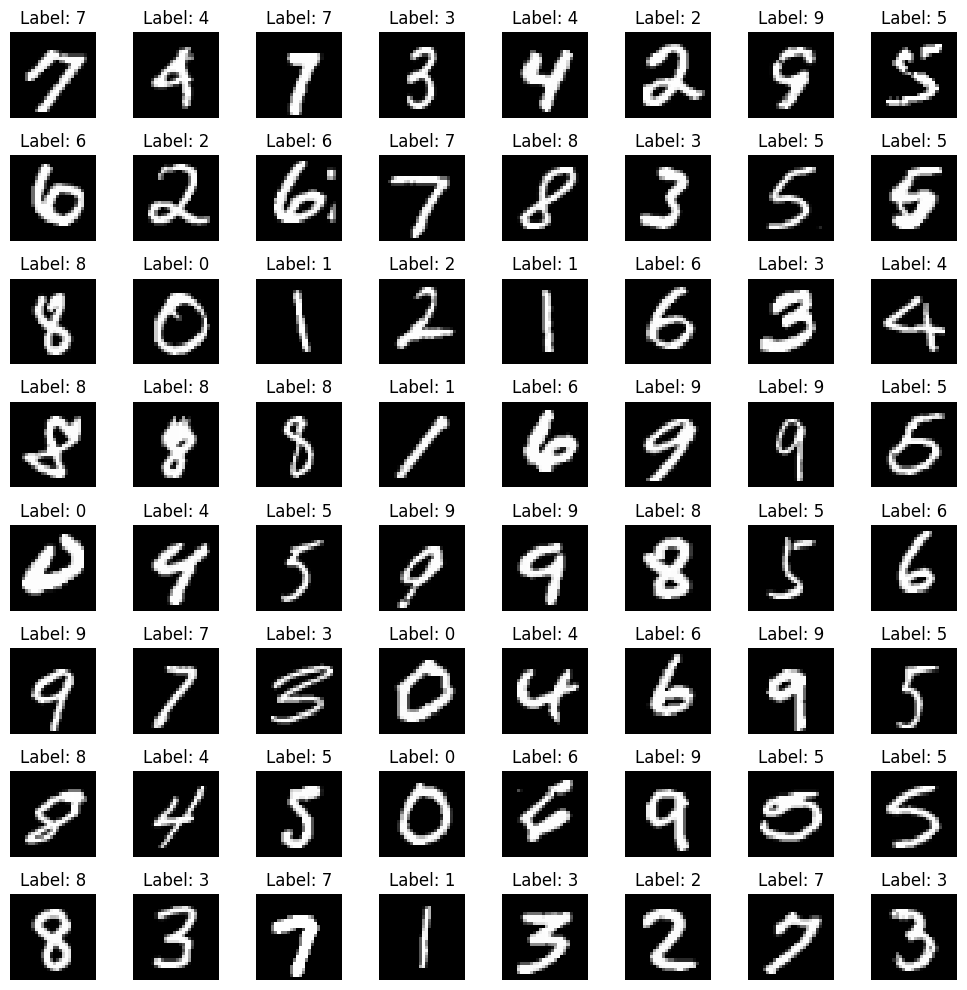

In [22]:
# Create an instance of the MNISTDataModule
data_module = MNISTDataModule(batch_size=64)

# Prepare the data and set up for 'fit' stage
data_module.prepare_data()
data_module.setup(stage='fit')

# Get a batch of data from the train DataLoader
train_loader = data_module.train_dataloader()
batch = next(iter(train_loader))  # Get the first batch
images, labels = batch

# Denormalize the images for visualization
images = images * 0.5 + 0.5  # Reverse normalization (from [-1, 1] to [0, 1])

# Function to plot a grid of images
def plot_images(images, labels, n=8):
    """
    Plots a grid of `n` x `n` images and their labels.

    Args:
        images (Tensor): Batch of images to plot.
        labels (Tensor): Corresponding labels for the images.
        n (int): Number of images to display per row/column.
    """
    plt.figure(figsize=(10, 10))
    for i in range(n * n):
        plt.subplot(n, n, i + 1)
        plt.imshow(images[i].squeeze(0), cmap="gray")
        plt.title(f"Label: {labels[i].item()}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Plot the first 8x8 images from the batch
plot_images(images, labels, n=8)

## CVAE model

In [11]:
class CVAE(pl.LightningModule):
    def __init__(self, input_dim=28 * 28, latent_dim=20, num_classes=10):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.num_classes = num_classes

        # Encoder
        self.encoder_fc1 = nn.Linear(input_dim + num_classes, 512)
        self.encoder_fc2 = nn.Linear(512, 256)
        self.encoder_fc_mean = nn.Linear(256, latent_dim)
        self.encoder_fc_logvar = nn.Linear(256, latent_dim)

        # Decoder
        self.decoder_fc1 = nn.Linear(latent_dim + num_classes, 256)
        self.decoder_fc2 = nn.Linear(256, 512)
        self.decoder_fc3 = nn.Linear(512, input_dim)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        # Dictionary to store logged metrics
        self.log_dict = {"train": {}, "val": {}, "test": {}}

    def encode(self, x, labels):
        # Concatenate the flattened image vector with the one-hot label
        x = torch.cat([x, labels], dim=1)
        x = self.relu(self.encoder_fc1(x))  # Hidden layer 1
        x = self.relu(self.encoder_fc2(x))  # Hidden layer 2
        mean = self.encoder_fc_mean(x)      # Output mean vector
        logvar = self.encoder_fc_logvar(x)  # Output log-variance vector
        return mean, logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)  # Compute standard deviation
        eps = torch.randn_like(std)    # Sample noise from standard normal
        return mean + eps * std        # Return reparameterized latent vector

    def decode(self, z, labels):
        # Concatenate latent vector with one-hot encoded label
        z = torch.cat([z, labels], dim=1)
        z = self.relu(self.decoder_fc1(z))  # Hidden layer 1
        z = self.relu(self.decoder_fc2(z))  # Hidden layer 2
        z = self.sigmoid(self.decoder_fc3(z))  # Reconstruct image
        return z

    def forward(self, x, labels):
        # Forward pass through the CVAE
        mean, logvar = self.encode(x, labels)
        z = self.reparameterize(mean, logvar)
        x_reconstructed = self.decode(z, labels)
        return x_reconstructed, mean, logvar

    def compute_loss(self, batch):
        """
        Computes the VAE loss for a batch of data.

        Args:
            batch: A tuple containing images and labels.

        Returns:
            loss: Total loss (reconstruction + KL divergence).
            recon_loss: Reconstruction loss only.
            kl_div: KL divergence loss only.
        """
        images, labels = batch
        images = images.view(-1, self.input_dim)  # Flatten images
        labels = nn.functional.one_hot(labels, num_classes=self.num_classes).float()  # One-hot encode labels

        # Forward pass
        x_reconstructed, mean, logvar = self(images, labels)

        # Reconstruction loss (BCE)
        recon_loss = nn.BCELoss(reduction='sum')(x_reconstructed, images)

        # KL divergence loss
        kl_div = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

        # Total loss
        loss = recon_loss + kl_div

        return loss, recon_loss, kl_div

    def training_step(self, batch, batch_idx):
        loss, recon_loss, kl_div = self.compute_loss(batch)
        self.log_dict["train"]["loss"] = loss.item()
        self.log_dict["train"]["recon_loss"] = recon_loss.item()
        self.log_dict["train"]["kl_div"] = kl_div.item()
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_recon_loss", recon_loss, prog_bar=True)
        self.log("train_kl_div", kl_div, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, recon_loss, kl_div = self.compute_loss(batch)
        self.log_dict["val"]["loss"] = loss.item()
        self.log_dict["val"]["recon_loss"] = recon_loss.item()
        self.log_dict["val"]["kl_div"] = kl_div.item()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_recon_loss", recon_loss, prog_bar=True)
        self.log("val_kl_div", kl_div, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


### Train

In [ ]:
import os
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
path = "/content/drive/MyDrive/GenAI/MNIST_CVAE/experiments/"
experiment_path = os.path.join(path, f"experiment_{timestamp}")
os.makedirs(experiment_path, exist_ok=True)

class LossLogger(Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = {"loss": [], "recon_loss": [], "kl_div": []}
        self.val_losses = {"loss": [], "recon_loss": [], "kl_div": []}

    def on_train_epoch_end(self, trainer, pl_module):
        # Retrieve and store training metrics from log_dict
        self.train_losses["loss"].append(pl_module.log_dict["train"]["loss"])
        self.train_losses["recon_loss"].append(pl_module.log_dict["train"]["recon_loss"])
        self.train_losses["kl_div"].append(pl_module.log_dict["train"]["kl_div"])

    def on_validation_epoch_end(self, trainer, pl_module):
        # Retrieve and store validation metrics from log_dict
        self.val_losses["loss"].append(pl_module.log_dict["val"]["loss"])
        self.val_losses["recon_loss"].append(pl_module.log_dict["val"]["recon_loss"])
        self.val_losses["kl_div"].append(pl_module.log_dict["val"]["kl_div"])

# Callbacks for training
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",  # Monitor validation loss
    mode="min",          # Minimize validation loss
    save_top_k=1,        # Save only the best model
    filename="best-cvae-{epoch:02d}-{val_loss:.2f}"  # Filename pattern
)

# Instantiate the data module
data_module = MNISTDataModule()

# Instantiate the model
model = CVAE()

# Logger for saving metrics
csv_logger = CSVLogger(
    save_dir=experiment_path,
    name='csv_logs',
    version=None
)

# Instantiate the loss logger
loss_logger = LossLogger()

# Trainer setup
trainer = Trainer(
    max_epochs=20,
    logger=csv_logger,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    callbacks=[loss_logger, checkpoint_callback],
    #precision='bf16-mixed'
    precision=32
)

# Train the model
trainer.fit(model, data_module)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type    | Params | Mode 
------------------------------------------------------
0 | encoder_fc1       | Linear  | 407 K  | train
1 | encoder_fc2       | Linear  | 131 K  | train
2 | encoder_fc_mean   | Linear  | 5.1 K  | train
3 | encoder_fc_logvar | Linear  | 5.1 K  | train
4 | decoder_fc1       | Linear  | 7.9 K  | train
5 | decoder_fc2       | Linear  | 131 K  | train
6 | decoder_fc3       | Linear  | 402 K  | train
7 | relu              | ReLU    | 0      | train
8 | sigmoid           | Sigmoid | 0      | train
------------------------------------------------------
1.1 M     Trainable para

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


## Convolutional CVAE

In [12]:
class ConvCVAE(pl.LightningModule):
    def __init__(self, latent_dim=20, num_classes=10):
        super(ConvCVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # Encoder
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # 28x28 -> 14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 14x14 -> 7x7
            nn.ReLU(),
            nn.Flatten()  # Flatten the output for the dense layer
        )
        self.encoder_fc = nn.Sequential(
            nn.Linear(64 * 7 * 7 + num_classes, 256),  # Include the one-hot encoded labels
            nn.ReLU()
        )
        self.encoder_mean = nn.Linear(256, latent_dim)
        self.encoder_logvar = nn.Linear(256, latent_dim)

        # Decoder
        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 256),
            nn.ReLU(),
            nn.Linear(256, 64 * 7 * 7),
            nn.ReLU()
        )
        self.decoder_deconv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # 14x14 -> 28x28
            nn.Sigmoid()  # Output in [0, 1]
        )

    def encode(self, x, labels):
        labels_one_hot = labels.view(labels.size(0), -1)  # Flatten one-hot encoded labels
        x = self.encoder_conv(x)  # Convolutional encoder
        x = torch.cat([x, labels_one_hot], dim=1)  # Concatenate label
        x = self.encoder_fc(x)
        mean = self.encoder_mean(x)
        logvar = self.encoder_logvar(x)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decode(self, z, labels):
        labels_one_hot = labels.view(labels.size(0), -1)
        z = torch.cat([z, labels_one_hot], dim=1)  # Concatenate latent vector with labels
        z = self.decoder_fc(z)
        z = z.view(-1, 64, 7, 7)  # Reshape for deconvolution
        z = self.decoder_deconv(z)
        return z

    def forward(self, x, labels):
        mean, logvar = self.encode(x, labels)
        z = self.reparameterize(mean, logvar)
        x_reconstructed = self.decode(z, labels)
        return x_reconstructed, mean, logvar

    def compute_loss(self, batch):
        images, labels = batch
        labels_one_hot = nn.functional.one_hot(labels, num_classes=self.num_classes).float().to(images.device)
        images = images.view(-1, 1, 28, 28)

        # Forward pass
        x_reconstructed, mean, logvar = self(images, labels_one_hot)

        # Reconstruction loss
        recon_loss = nn.BCELoss(reduction='sum')(x_reconstructed, images)

        # KL divergence
        kl_div = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

        loss = recon_loss + kl_div
        return loss, recon_loss, kl_div

    def training_step(self, batch, batch_idx):
        loss, recon_loss, kl_div = self.compute_loss(batch)
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_recon_loss", recon_loss, prog_bar=True)
        self.log("train_kl_div", kl_div, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, recon_loss, kl_div = self.compute_loss(batch)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_recon_loss", recon_loss, prog_bar=True)
        self.log("val_kl_div", kl_div, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

### Train

In [ ]:
import os
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
path = "/content/drive/MyDrive/GenAI/MNIST_CVAE/experiments/"
experiment_path = os.path.join(path, f"ConvCVAE_{timestamp}")
os.makedirs(experiment_path, exist_ok=True)

# Instantiate the model
latent_dim = 20
num_classes = 10
model = ConvCVAE(latent_dim=latent_dim, num_classes=num_classes)

# Instantiate the data module (assuming MNISTDataModule is already defined)
data_module = MNISTDataModule()

# Callbacks for training
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",  # Monitor validation loss
    mode="min",          # Minimize validation loss
    save_top_k=1,        # Save only the best model
    filename="best-cvae-{epoch:02d}-{val_loss:.2f}"  # Filename pattern
)

# Logger for saving metrics
csv_logger = CSVLogger(
    save_dir=experiment_path,
    name='csv_logs',
    version=None
)

# Trainer setup
trainer = Trainer(
    max_epochs=20,
    logger=csv_logger,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    callbacks=[checkpoint_callback],
    #precision='bf16-mixed'
    precision=32
)

# Train the model
trainer.fit(model, data_module)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.6MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 494kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 10.7MB/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type       | Params | Mode 
------------------------------------------------------
0 | encoder_conv   | Sequential | 33.4 K | train
1 | encoder_fc     | Sequential | 805 K  | train
2 | encoder_mean   | Linear     | 5.1 K  | train
3 | encoder_logvar | Linear     | 5.1 K  | train
4 | decoder_fc     | Sequential | 813 K  | train
5 | decoder_deconv | Sequential | 33.3 K | train
------------------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.786     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


# Convolutional CVAE II

In [17]:
class ConvCVAE_II(pl.LightningModule):
    def __init__(self, latent_dim=100, num_classes=10, beta=4):
        super(ConvCVAE_II, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.beta = beta  # Weight for KL divergence in Beta-VAE

        # Encoder
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # 28x28 -> 14x14
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # 14x14 -> 7x7
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 7x7 -> 3x3
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Flatten()  # Flatten the output for the dense layer
        )
        self.encoder_fc = nn.Sequential(
            nn.Linear(64 * 4 * 4 + num_classes, 256),  # Include the one-hot encoded labels
            nn.BatchNorm1d(256),
            nn.ReLU()
        )
        self.encoder_mean = nn.Linear(256, latent_dim)
        self.encoder_logvar = nn.Linear(256, latent_dim)

        # Decoder
        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 64 * 4 * 4),
            nn.BatchNorm1d(64 * 4 * 4),
            nn.ReLU()
        )
        self.decoder_deconv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=0),  # 3x3 -> 7x7
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 7x7 -> 14x14
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2,padding=1, output_padding=1),  # 14x14 -> 28x28
            nn.Sigmoid()  # Output in [0, 1]
        )

    def encode(self, x, labels):
        labels_one_hot = labels.view(labels.size(0), -1)  # Flatten one-hot encoded labels
        x = self.encoder_conv(x)  # Convolutional encoder
        x = torch.cat([x, labels_one_hot], dim=1)  # Concatenate label
        x = self.encoder_fc(x)
        mean = self.encoder_mean(x)
        logvar = self.encoder_logvar(x)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decode(self, z, labels):
        labels_one_hot = labels.view(labels.size(0), -1)
        z = torch.cat([z, labels_one_hot], dim=1)  # Concatenate latent vector with labels
        z = self.decoder_fc(z)
        z = z.view(-1, 64, 4, 4)  # Reshape for deconvolution
        z = self.decoder_deconv(z)

        return z

    def forward(self, x, labels):
        mean, logvar = self.encode(x, labels)
        z = self.reparameterize(mean, logvar)
        x_reconstructed = self.decode(z, labels)
        return x_reconstructed, mean, logvar

    def compute_loss(self, batch):
        images, labels = batch
        labels_one_hot = nn.functional.one_hot(labels, num_classes=self.num_classes).float().to(images.device)
        images = images.view(-1, 1, 28, 28)

        # Forward pass
        x_reconstructed, mean, logvar = self(images, labels_one_hot)

        # Reconstruction loss
        recon_loss = nn.BCELoss(reduction='sum')(x_reconstructed, images)

        # KL divergence
        kl_div = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

        # Total loss with Beta-VAE
        loss = recon_loss + self.beta * kl_div
        return loss, recon_loss, kl_div

    def training_step(self, batch, batch_idx):
        loss, recon_loss, kl_div = self.compute_loss(batch)
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_recon_loss", recon_loss, prog_bar=True)
        self.log("train_kl_div", kl_div, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, recon_loss, kl_div = self.compute_loss(batch)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_recon_loss", recon_loss, prog_bar=True)
        self.log("val_kl_div", kl_div, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


## Train

In [ ]:
import os
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
path = "/content/drive/MyDrive/GenAI/MNIST_CVAE_II/experiments/"
experiment_path = os.path.join(path, f"ConvCVAE_II_{timestamp}")
os.makedirs(experiment_path, exist_ok=True)

# Instantiate the model
latent_dim = 100
num_classes = 10
beta = 4
model = ConvCVAE_II(latent_dim=latent_dim, num_classes=num_classes,beta=beta)

# Instantiate the data module
data_module = MNISTDataModule()

# Callbacks for training
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",  # Monitor validation loss
    mode="min",          # Minimize validation loss
    save_top_k=1,        # Save only the best model
    filename="best-cvae-{epoch:02d}-{val_loss:.2f}"  # Filename pattern
)

# Logger for saving metrics
csv_logger = CSVLogger(
    save_dir=experiment_path,
    name='csv_logs',
    version=None
)

# Trainer setup
trainer = Trainer(
    max_epochs=50,
    logger=csv_logger,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    callbacks=[checkpoint_callback],
    #precision='bf16-mixed'
    precision=32
)

# Train the model
trainer.fit(model, data_module)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type       | Params | Mode 
------------------------------------------------------
0 | encoder_conv   | Sequential | 23.5 K | train
1 | encoder_fc     | Sequential | 265 K  | train
2 | encoder_mean   | Linear     | 25.7 K | train
3 | encoder_logvar | Linear     | 25.7 K | train
4 | decoder_fc     | Sequential | 294 K  | train
5 | decoder_deconv | Sequential | 23.3 K | train
------------------------------------------------------
657 K     Trainable params
0         Non-trainable params
657 K     Total params
2.631     Total estimated model params size (MB)
33        Modules in train mode
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


# Evaluate

### Plot loss

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(loss_logger):
    """
    Plots the training and validation losses logged by the LossLogger callback.

    Args:
        loss_logger: The LossLogger instance that contains training and validation metrics.
    """
    # Ensure train and validation losses are aligned
    epochs_train = len(loss_logger.train_losses["loss"])
    epochs_val = len(loss_logger.val_losses["loss"])

    # Use the minimum length to avoid mismatches
    epochs = min(epochs_train, epochs_val)

    # Slice losses to the same length
    train_loss = loss_logger.train_losses["loss"][:epochs]
    val_loss = loss_logger.val_losses["loss"][:epochs]
    train_recon_loss = loss_logger.train_losses["recon_loss"][:epochs]
    val_recon_loss = loss_logger.val_losses["recon_loss"][:epochs]
    train_kl_div = loss_logger.train_losses["kl_div"][:epochs]
    val_kl_div = loss_logger.val_losses["kl_div"][:epochs]

    # Create a figure with 3 subplots for each type of loss
    plt.figure(figsize=(12, 8))

    # Total Loss
    plt.subplot(3, 1, 1)
    plt.plot(range(epochs), train_loss, label="Training Loss", marker='o')
    plt.plot(range(epochs), val_loss, label="Validation Loss", marker='o')
    plt.title("Total Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()

    # Reconstruction Loss
    plt.subplot(3, 1, 2)
    plt.plot(range(epochs), train_recon_loss, label="Training Reconstruction Loss", marker='o')
    plt.plot(range(epochs), val_recon_loss, label="Validation Reconstruction Loss", marker='o')
    plt.title("Reconstruction Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()

    # KL Divergence
    plt.subplot(3, 1, 3)
    plt.plot(range(epochs), train_kl_div, label="Training KL Divergence", marker='o')
    plt.plot(range(epochs), val_kl_div, label="Validation KL Divergence", marker='o')
    plt.title("KL Divergence")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Call the function after training
plot_metrics(loss_logger)


NameError: name 'loss_logger' is not defined

### Plot latent space

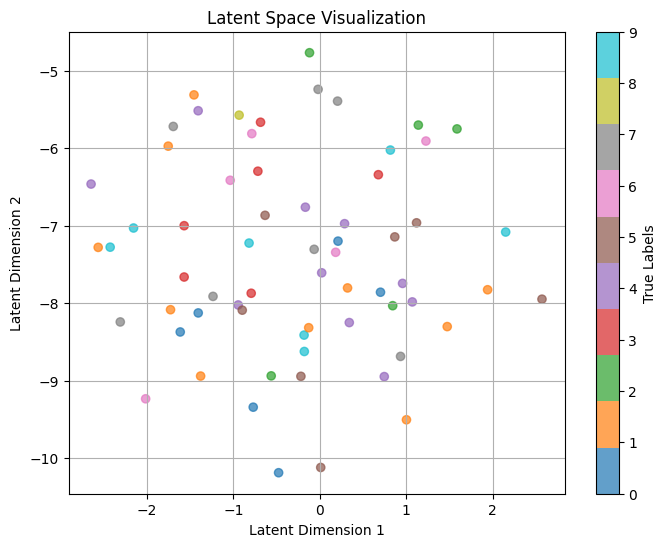

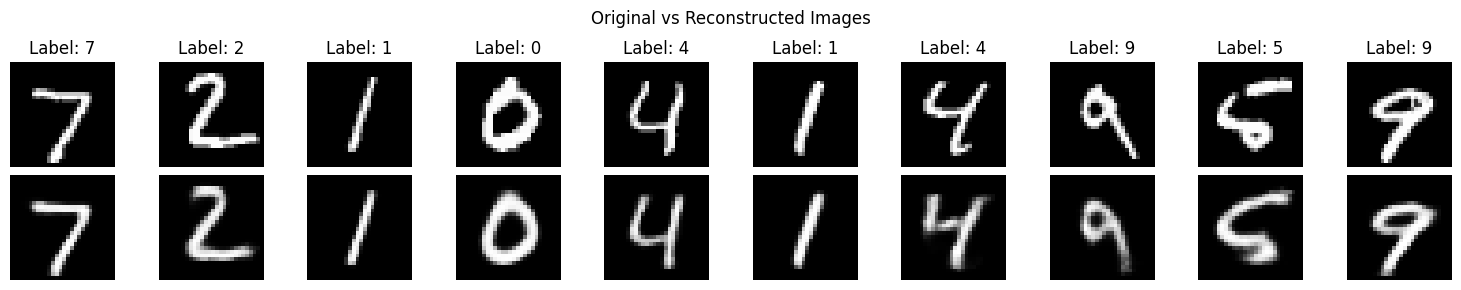

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torchvision.utils import make_grid

# Assuming the model and data_module are already initialized and loaded
# Load the test data
# Instantiate the data module
data_module.setup(stage='test')
test_loader = data_module.test_dataloader()

# Get a batch of test data
test_images, test_labels = next(iter(test_loader))
test_images = test_images.view(test_images.size(0), -1)  # Flatten images

# Ensure the model is in evaluation mode
model.eval()

# Get latent representations
with torch.no_grad():
    one_hot_labels = torch.nn.functional.one_hot(test_labels, num_classes=model.num_classes).float()
    mean, logvar = model.encode(test_images, one_hot_labels)
    z = model.reparameterize(mean, logvar)

# Check if latent space is 2D or higher-dimensional
latent_dim = z.shape[1]
if latent_dim > 2:
    # Use t-SNE to reduce dimensions to 2D
    z_2d = TSNE(n_components=2, random_state=42).fit_transform(z.numpy())
else:
    z_2d = z.numpy()

# Plot the latent space
plt.figure(figsize=(8, 6))
scatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=test_labels.numpy(), cmap='tab10', alpha=0.7)
plt.colorbar(scatter, label='True Labels')
plt.title("Latent Space Visualization")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.grid()
plt.show()

# Reconstruction Examples
with torch.no_grad():
    reconstructed_images = model.decode(z, one_hot_labels).view(-1, 1, 28, 28)  # Reshape to original

# Plot original vs reconstructed images
fig, axes = plt.subplots(2, 10, figsize=(15, 3))

# First row: Original images
for i in range(10):
    axes[0, i].imshow(test_images[i].view(28, 28).numpy(), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title(f"Label: {test_labels[i].item()}")

# Second row: Reconstructed images
for i in range(10):
    axes[1, i].imshow(reconstructed_images[i].squeeze().numpy(), cmap='gray')
    axes[1, i].axis('off')

plt.suptitle("Original vs Reconstructed Images", y=0.95)
plt.tight_layout()
plt.show()


## Generate images

In [19]:
def generate_images(model, num_samples=10):
    """
    Genera imágenes a partir de estados latentes aleatorios para cada etiqueta.

    Args:
        model: Modelo CVAE entrenado.
        num_samples: Número de imágenes por etiqueta.

    Returns:
        Un diccionario con imágenes generadas por etiqueta.
    """
    model.eval()  # Modo evaluación
    generated_images = {}

    # Iterar por etiquetas (0 a 9)
    for label in range(10):
        # Crear estados latentes aleatorios z ~ N(0, 1)
        z = torch.randn(num_samples, model.latent_dim).to(device)

        # Crear etiquetas one-hot
        labels_one_hot = torch.zeros(num_samples, model.num_classes).to(device)
        labels_one_hot[:, label] = 1

        # Decodificar las imágenes generadas
        with torch.no_grad():
            decoded_images = model.decode(z, labels_one_hot).view(-1, 1, 28, 28)

        # Guardar las imágenes generadas por etiqueta
        generated_images[label] = decoded_images.cpu()

    return generated_images

# Visualizar las imágenes generadas
def plot_generated_images(generated_images,name_model):
    """
    Muestra imágenes generadas para cada etiqueta.

    Args:
        generated_images: Diccionario con imágenes generadas por etiqueta.
    """
    fig, axes = plt.subplots(10, 10, figsize=(15, 15))
    for label, images in generated_images.items():
        for i in range(10):  # 10 muestras por etiqueta
            axes[label, i].imshow(images[i].squeeze(), cmap='gray')
            axes[label, i].axis('off')
    plt.suptitle(name_model, y=1)
    plt.tight_layout()
    plt.show()

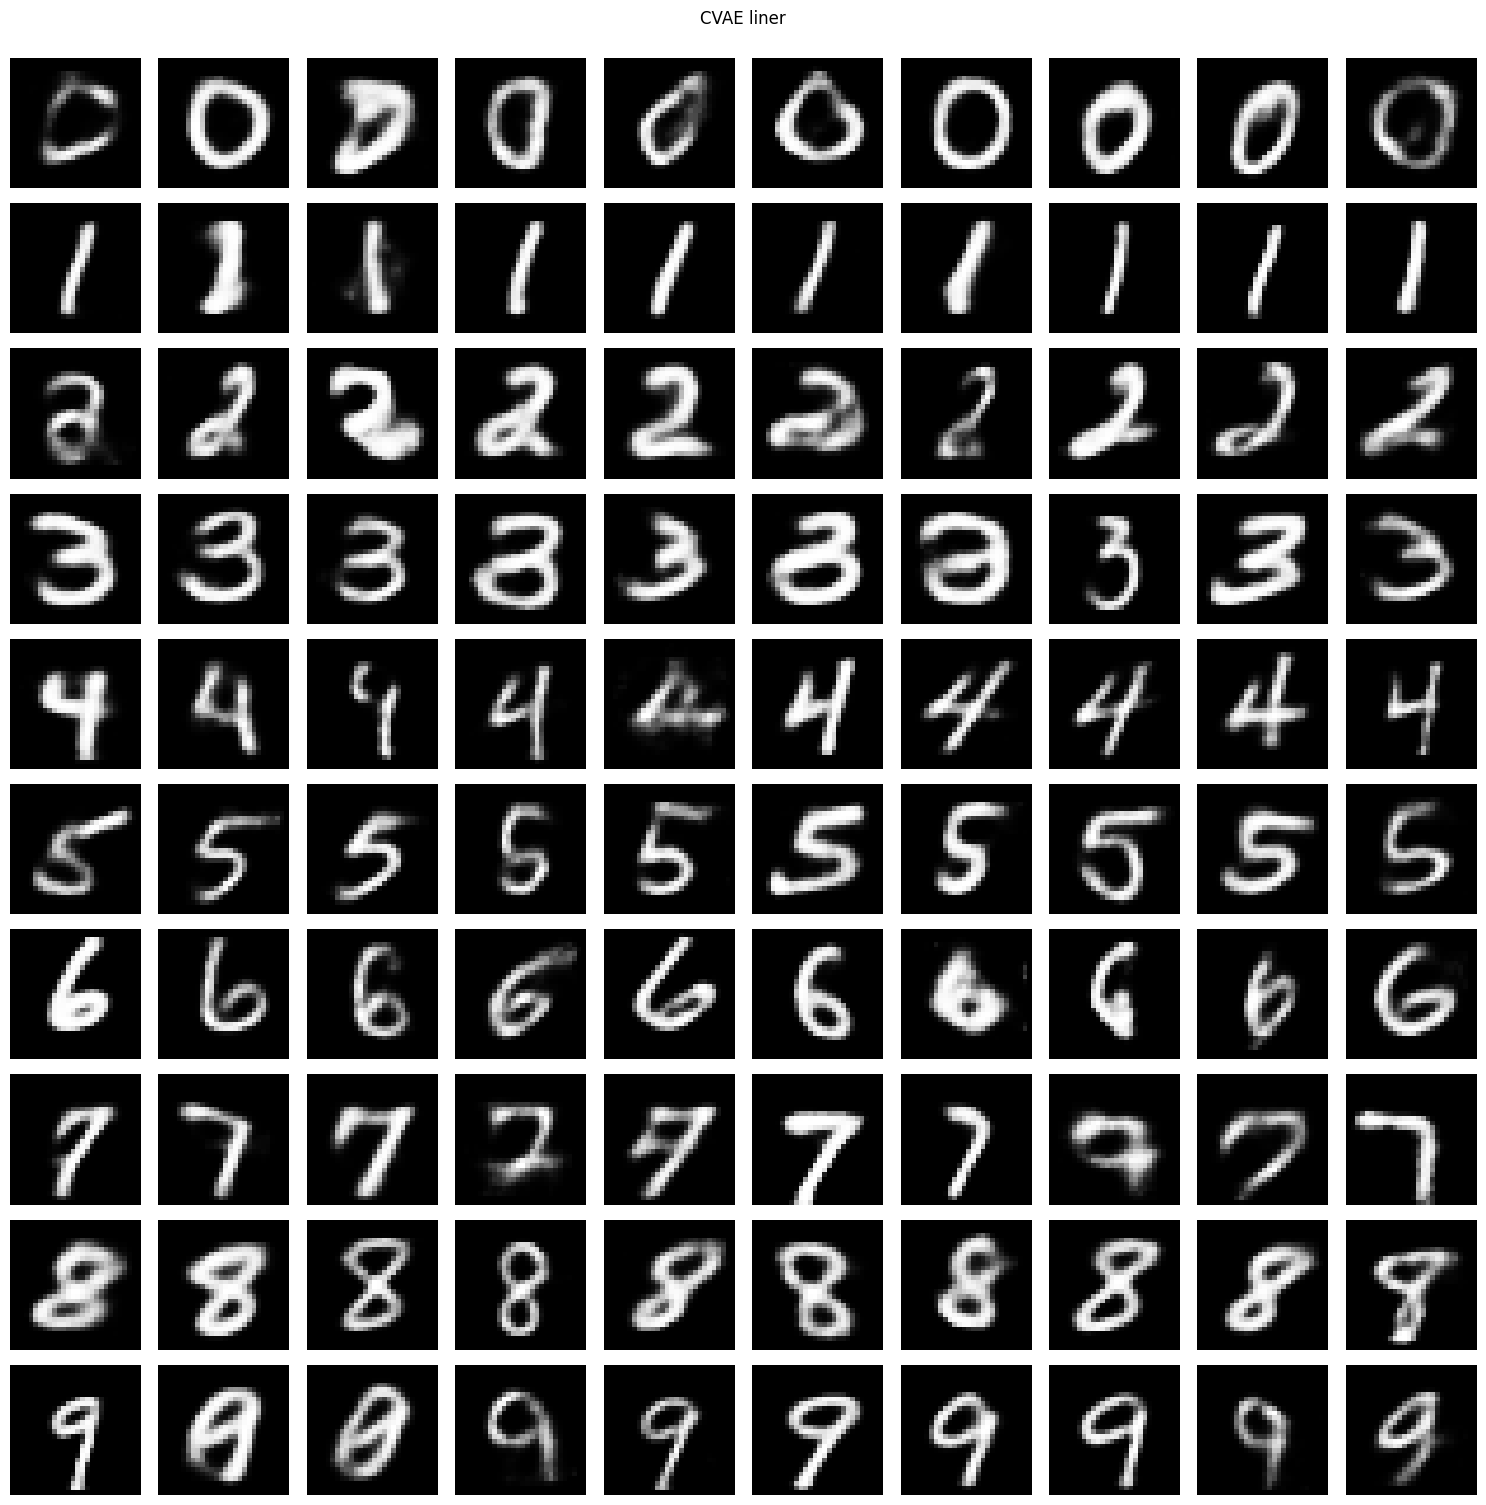

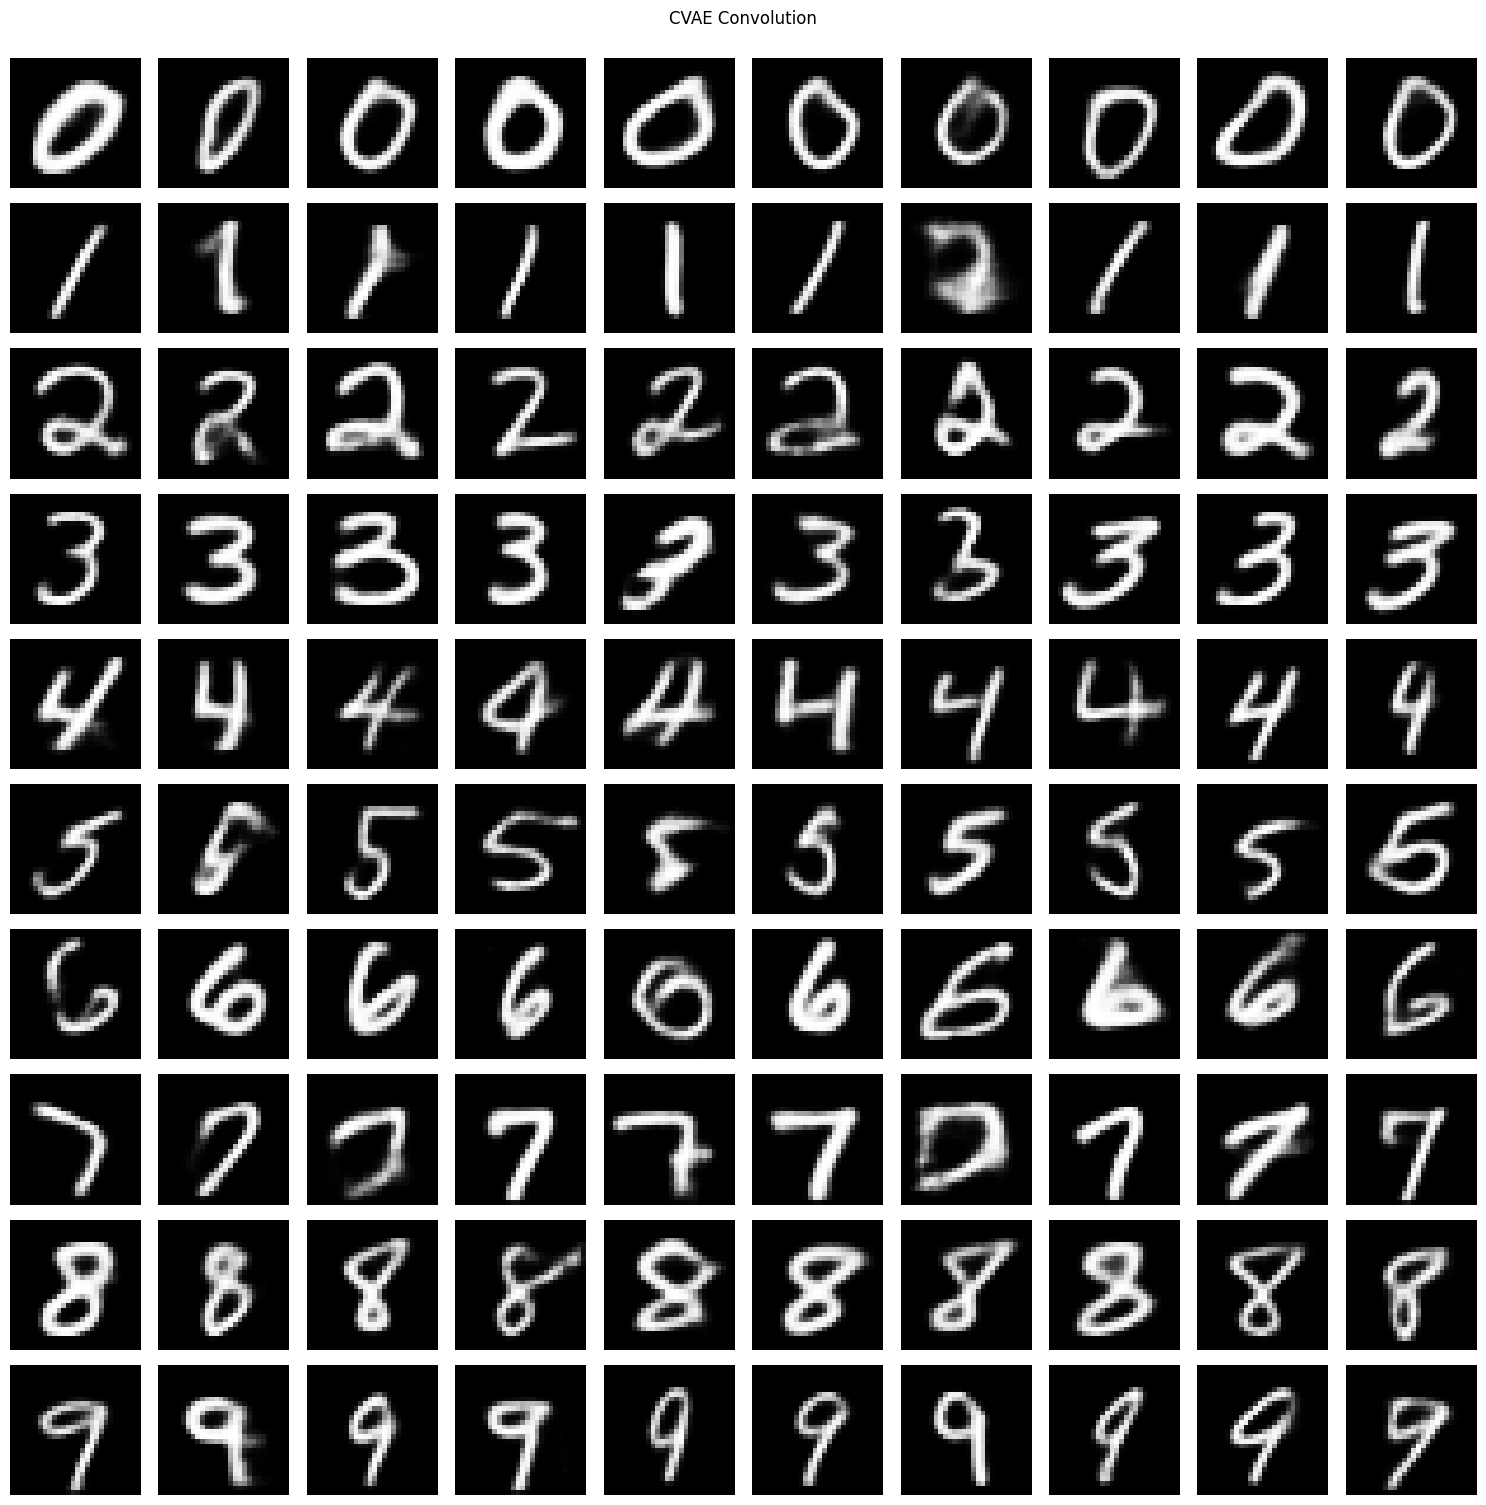

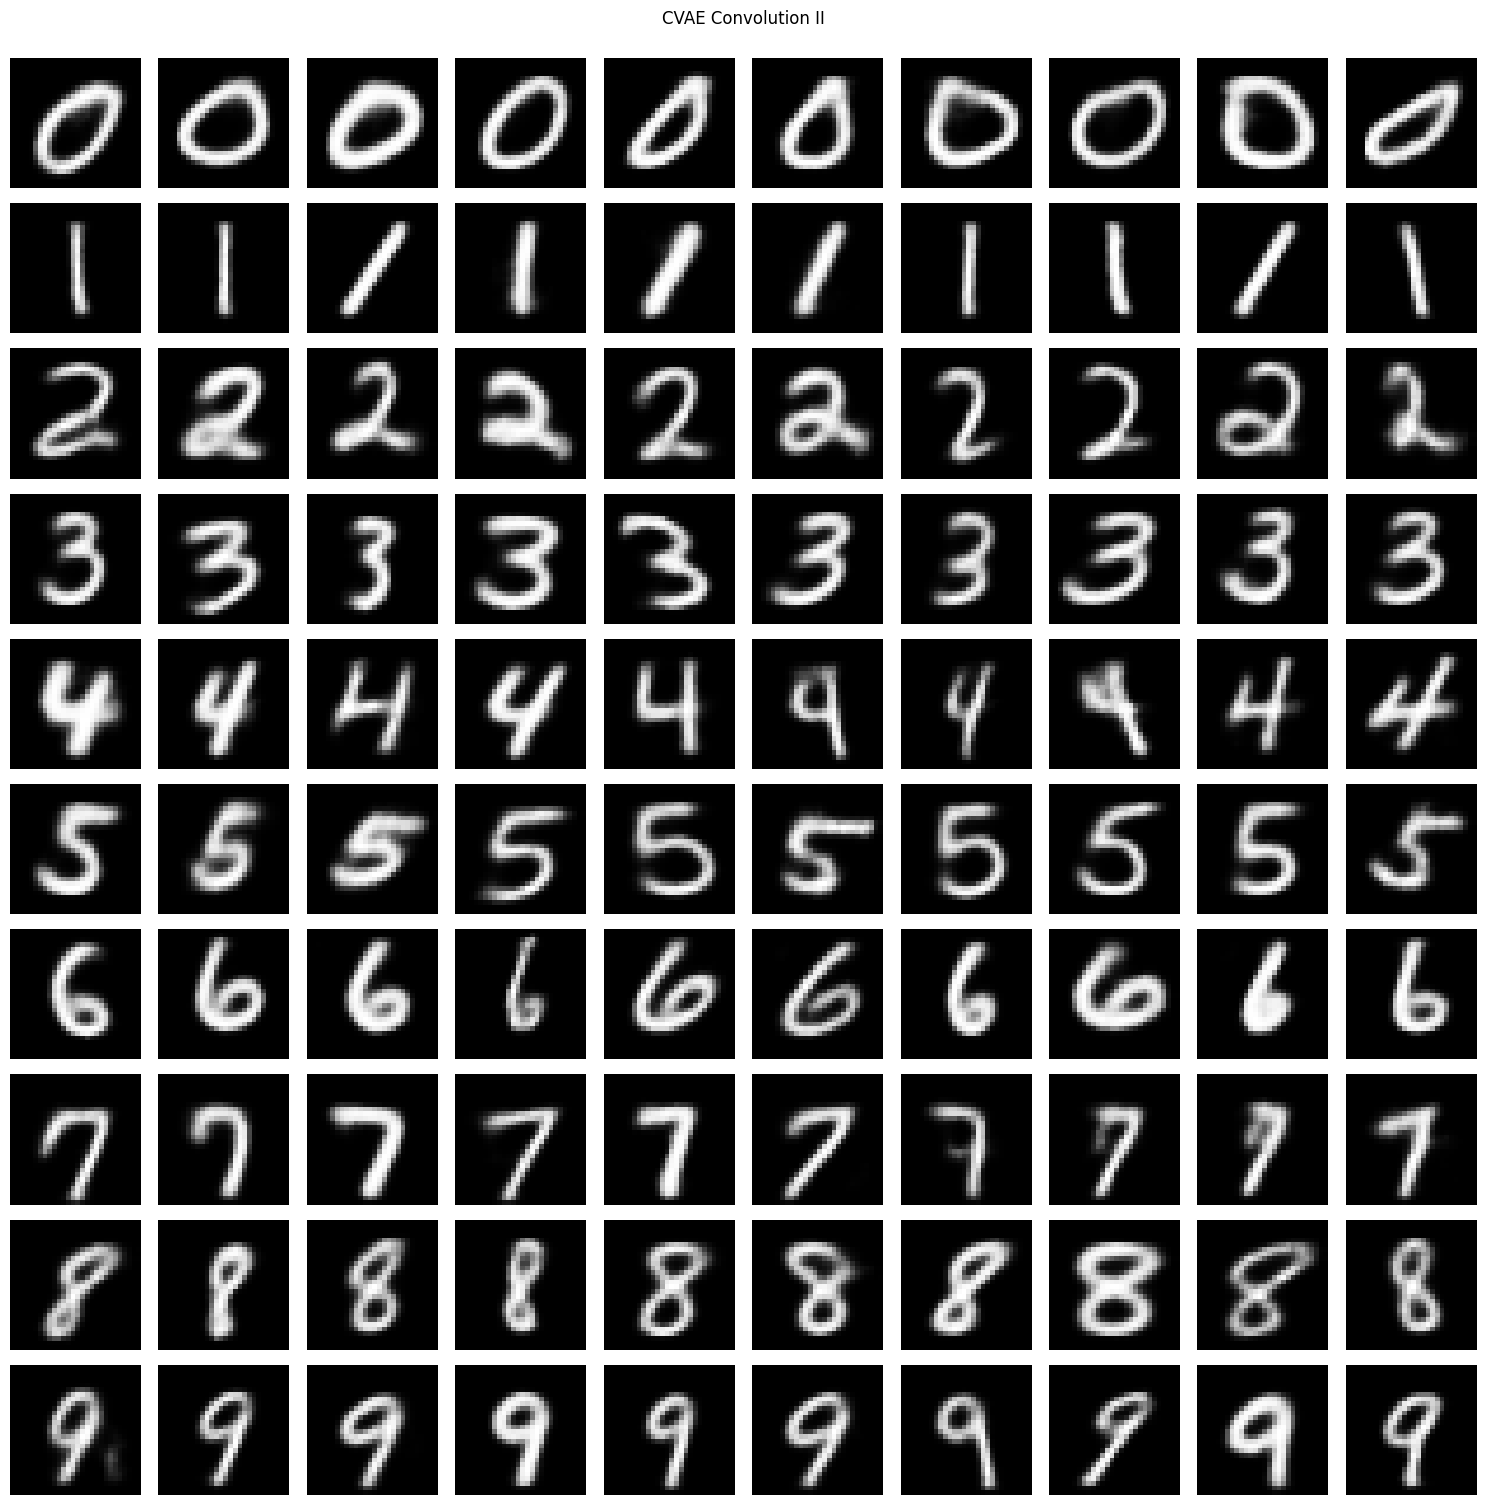

In [20]:
# Ruta del mejor modelo
best_model_cvae = "/content/drive/MyDrive/GenAI/MNIST_CVAE/experiments/experiment_20250125-181421/csv_logs/version_0/checkpoints/best-cvae-epoch=18-val_loss=6172.31.ckpt"
best_model_ConvCVAE = "/content/drive/MyDrive/GenAI/MNIST_CVAE/experiments/ConvCVAE_20250125-203107/csv_logs/version_0/checkpoints/best-cvae-epoch=19-val_loss=5913.26.ckpt"
best_model_ConvCVAE_II = '/content/drive/MyDrive/GenAI/MNIST_CVAE_II/experiments/ConvCVAE_II_20250126-210839/csv_logs/version_0/checkpoints/best-cvae-epoch=46-val_loss=8066.11.ckpt'

best_models = {
    'CVAE liner':[best_model_cvae,CVAE],
    'CVAE Convolution':[best_model_ConvCVAE,ConvCVAE],
    'CVAE Convolution II':[best_model_ConvCVAE_II,ConvCVAE_II]
}

for title, model in best_models.items():

  model = model[1].load_from_checkpoint(model[0])
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  generated_images = generate_images(model)

  # Visualizar las imágenes generadas
  plot_generated_images(generated_images,title)